In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

!unzip \*.zip && rm *.zip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
License(s): CC0-1.0
 98% 63.0M/64.4M [00:04<00:00, 19.5MB/s]
100% 64.4M/64.4M [00:04<00:00, 15.0MB/s]
Archive:  cats-and-dogs-image-classification.zip
  inflating: test/cats/cat_1.jpg     
  inflating: test/cats/cat_106.jpg   
  inflating: test/cats/cat_109.jpg   
  inflating: test/cats/cat_113.jpg   
  inflating: test/cats/cat_114.jpg   
  inflating: test/cats/cat_116.jpg   
  inflating: test/cats/cat_118.jpg   
  inflating: test/cats/cat_119.jpg   
  inflating: test/cats/cat_124.jpg   
  inflating: test/cats/cat_140.jpg   
  inflating: test/cats/cat_147.jpg   
  inflating: test/cats/cat_156.jpg   
  inflating: test/cats/cat_158.jpg   
  inflating: test/cats/cat_162.jpg   
  inflating: test/cats/cat_18.jpg    
  inflating: test/cats/cat_190.jpg   
  inflating: test/cats/cat_203.jpg   
  inflating: test/cats/cat_223.jpg   
  inflating: test/cats/cat_234.jpg   
  inf

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    }

In [6]:
data_dir = 'data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['cats', 'dogs']


In [7]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

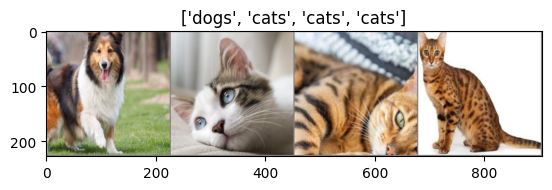

In [9]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [14]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [15]:
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [17]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5467 Acc: 0.7325
val Loss: 0.3180 Acc: 0.9000

Epoch 1/24
----------
train Loss: 0.4106 Acc: 0.8079
val Loss: 0.1988 Acc: 0.9143

Epoch 2/24
----------
train Loss: 0.3836 Acc: 0.8259
val Loss: 0.1535 Acc: 0.9357

Epoch 3/24
----------
train Loss: 0.3624 Acc: 0.8420
val Loss: 0.1387 Acc: 0.9429

Epoch 4/24
----------
train Loss: 0.3359 Acc: 0.8492
val Loss: 0.1251 Acc: 0.9429

Epoch 5/24
----------
train Loss: 0.3686 Acc: 0.8187
val Loss: 0.1067 Acc: 0.9643

Epoch 6/24
----------
train Loss: 0.3034 Acc: 0.8636
val Loss: 0.1153 Acc: 0.9643

Epoch 7/24
----------
train Loss: 0.3495 Acc: 0.8366
val Loss: 0.1422 Acc: 0.9214

Epoch 8/24
----------
train Loss: 0.3260 Acc: 0.8582
val Loss: 0.1206 Acc: 0.9571

Epoch 9/24
----------
train Loss: 0.2623 Acc: 0.8761
val Loss: 0.0982 Acc: 0.9929

Epoch 10/24
----------
train Loss: 0.3305 Acc: 0.8420
val Loss: 0.0933 Acc: 0.9929

Epoch 11/24
----------
train Loss: 0.3230 Acc: 0.8420
val Loss: 0.1278 Acc: 0.9500

Ep

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [19]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [20]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5008 Acc: 0.7469
val Loss: 0.1793 Acc: 0.9071

Epoch 1/24
----------
train Loss: 0.4797 Acc: 0.7953
val Loss: 0.0971 Acc: 0.9786

Epoch 2/24
----------
train Loss: 0.4144 Acc: 0.8187
val Loss: 0.0830 Acc: 0.9714

Epoch 3/24
----------
train Loss: 0.3977 Acc: 0.8348
val Loss: 0.0953 Acc: 0.9571

Epoch 4/24
----------
train Loss: 0.4676 Acc: 0.8151
val Loss: 0.0723 Acc: 0.9786

Epoch 5/24
----------
train Loss: 0.4317 Acc: 0.8241
val Loss: 0.1364 Acc: 0.9286

Epoch 6/24
----------
train Loss: 0.4389 Acc: 0.8276
val Loss: 0.1469 Acc: 0.9500

Epoch 7/24
----------
train Loss: 0.4087 Acc: 0.8348
val Loss: 0.1028 Acc: 0.9714

Epoch 8/24
----------
train Loss: 0.3568 Acc: 0.8366
val Loss: 0.1105 Acc: 0.9571

Epoch 9/24
----------
train Loss: 0.2981 Acc: 0.8671
val Loss: 0.0861 Acc: 0.9714

Epoch 10/24
----------
train Loss: 0.2925 Acc: 0.8743
val Loss: 0.1095 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.3036 Acc: 0.8671
val Loss: 0.0890 Acc: 0.9500

Ep